In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

# Reading, Understanding and Visualising the data

In [3]:
#read the data
bike_df = pd.read_csv("day.csv")

In [4]:
#data preview
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data cleaning

We see there are no missing values in any of the columns.The data type matches the data stored in the columns.

Columns like instant, dteday are not providing any new info. While instant is kind of an index, the info in dteday is already available as month and year. We can drop these columns.

In [6]:
#dropping columns instant and dteday
bike_df = bike_df.drop(['instant','dteday'],axis=1)

Variables like season, weathersit are encoded as 1,2 making it appear ordered while infact they are not. It is better to represent them as categorical variables

<b> Creating categorical variables out of encoded variables </b>

In [7]:
#mapping as provided in the data dictionary
season_map = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
weather_map = {1:"Clear",2:"Cloudy",3:"Light Precipitation",4:"Heavy Precipitation"}
weekday_map = {1:"Mon",2:"Tues",3:"Wed",4:"Thurs",5:"Fri",6:"Sat",7:"Sun"}
month_map = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}

In [8]:
bike_df["season"] = bike_df["season"].map(season_map)

bike_df["weathersit"] = bike_df["weathersit"].map(weather_map)

bike_df["weekday"] = bike_df["weekday"].map(weekday_map)

bike_df["month_text"] = bike_df["mnth"].map(month_map)

In [9]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,month_text
0,spring,0,1,0,Mon,1,Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,Jan
1,spring,0,1,0,Tues,1,Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,Jan
2,spring,0,1,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,Jan
3,spring,0,1,0,Thurs,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,Jan
4,spring,0,1,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,Jan


### Data Visualization

Visualizing the data can help us identify patterns and understand the data better. 

### Numerical variables vs target variable

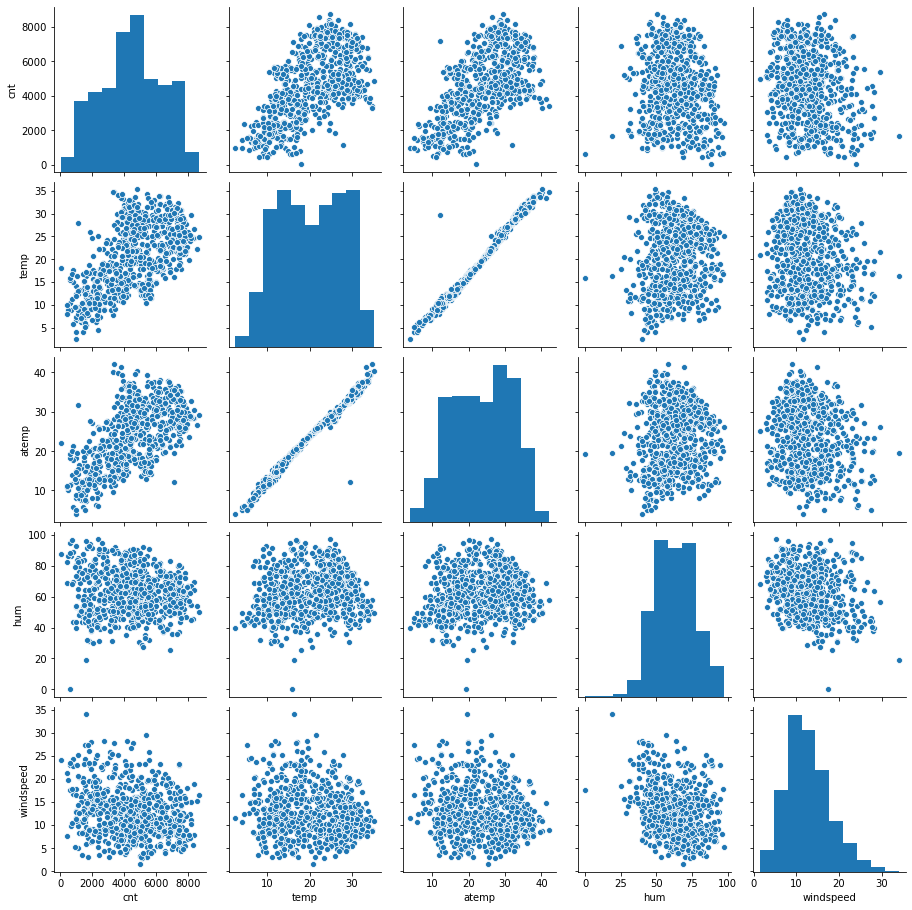

In [10]:
#plotting scatterplots for selected numerical columns
numvars = ['cnt','temp','atemp','hum','windspeed']
sns.pairplot(bike_df[numvars]);

#### Inferences

We see some linear relationship between cnt and temp, cnt and atemp. However, there is a very strong linear relationship between temp and atemp. Using both variables in our model could lead to Muticollinearity.

Other observations :
- The number of bookings are very less when the windspeed is high. 
- The number of bookings is very less when the humidity is low.

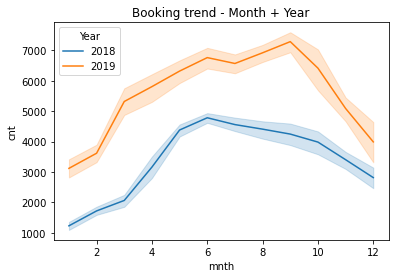

In [11]:
#bike rental trend across months for the years 2018 and 2019
sns.lineplot(x=bike_df['mnth'],y=bike_df['cnt'],hue=bike_df['yr']);
plt.legend(title='Year', loc='upperr right', labels=['2018', '2019']);
plt.title("Booking trend - Month + Year");

#### Inferences
The number of bookings have different peaks across months for 2018 and 2019.The number of bikes booked in 2019 is much higher than 2018, which could mean the bikes are gaining popularity.

### Categorical variables vs target variable

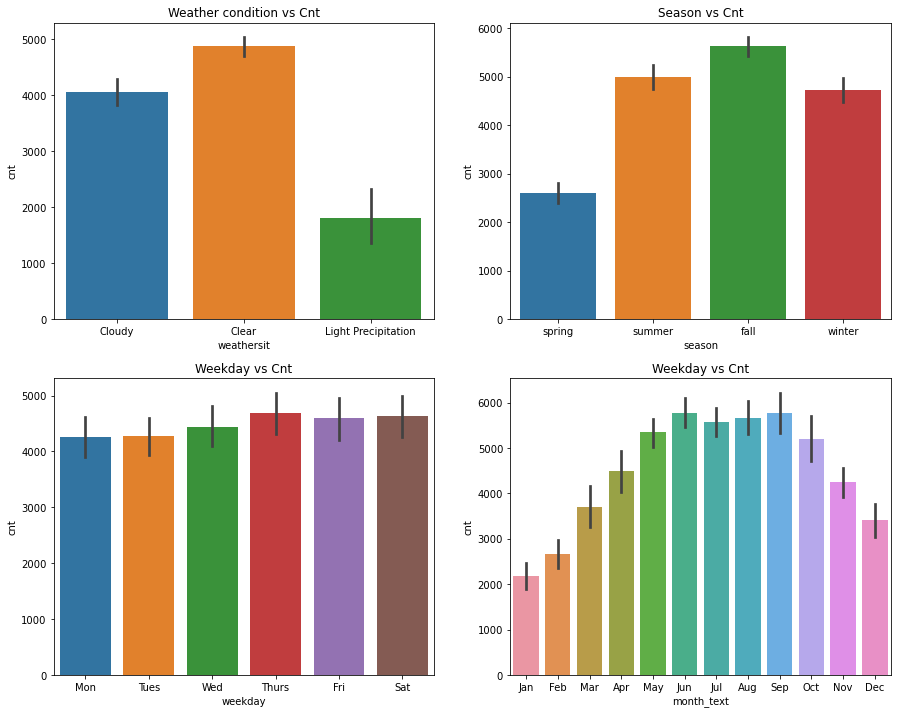

In [12]:
#sns.scatterplot(data = bike_df,y='cnt',x = 'atemp',hue='season');
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.barplot(bike_df['weathersit'],bike_df['cnt']);
plt.title("Weather condition vs Cnt");

plt.subplot(2,2,2)
sns.barplot(bike_df['season'],bike_df['cnt']);
plt.title("Season vs Cnt");

plt.subplot(2,2,3)
sns.barplot(bike_df['weekday'],bike_df['cnt']);
plt.title("Weekday vs Cnt");

plt.subplot(2,2,4)
sns.barplot(bike_df['month_text'],bike_df['cnt']);
plt.title("Weekday vs Cnt");


#### Inferences
The number of bikes booked is the highest when the weather is Clear/Partly cloudy and lowest for light precipitation. We also observe, there is no data corresponding to severe weather conditions such as Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog. 

The number of bikes booked is the highest for fall season and lowest for spring season.

While the number of books appear similar across weekdays, the trend shows higher bookings around midweek - highest on thursday and second highest on wednesday. The lowest booking is on Monday.

The demand for bikes seem to be at the peak mid year around Jun - Sep, with lesser in Jul and Aug than in Jun and Sep

## Data preperation

### Dummy variables

In [13]:
#creating m-1 dummy variables for categorical column with m levels 
season = pd.get_dummies(bike_df['season'],drop_first=True)
weather = pd.get_dummies(bike_df['weathersit'],drop_first=True)
weekday = pd.get_dummies(bike_df['weekday'],drop_first = True)
month = pd.get_dummies(bike_df['month_text'],drop_first = True)

In [14]:
season.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [15]:
weather.head()

,Cloudy,Light Precipitation
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [16]:
weekday.head()

,Mon,Sat,Thurs,Tues,Wed
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,1,0,0
4,0,0,0,0,0


In [17]:
month.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [18]:
#adding dummy variables to the dataset
bike_df = pd.concat([bike_df,season,weather,weekday,month],axis=1)
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,spring,0,1,0,Mon,1,Cloudy,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,0,0
1,spring,0,1,0,Tues,1,Cloudy,14.902598,17.68695,69.6087,...,0,0,1,0,0,0,0,0,0,0
2,spring,0,1,0,Wed,1,Clear,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,0
3,spring,0,1,0,Thurs,1,Clear,8.200000,10.60610,59.0435,...,0,0,1,0,0,0,0,0,0,0
4,spring,0,1,0,Fri,1,Clear,9.305237,11.46350,43.6957,...,0,0,1,0,0,0,0,0,0,0


The columns casual and registered give us information about the user who booked a bike. This will not be of use in our prediction model. We can drop these columns. 

The categorical variables have also been added as dummy variables, so they are redundant now. We can drop these columns as well.

In [19]:
#dropping unwanted columns and the categorical columns for which dummy variables have been created and the dependant variables we don't need
bike_df = bike_df.drop(['season','weathersit','weekday','casual','registered','mnth','month_text'],axis=1)
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


### Splitting the data set to train and test data set

In [20]:
df_train,df_test = train_test_split(bike_df,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


### Rescaling features

In [21]:
#using min max scaling to rescale features 

#1. Instantiate an object
scaler = MinMaxScaler()

#create a list of numeric variables
numvars = ['temp','atemp','hum','windspeed','cnt']

#2. Fit on a data
df_train[numvars] = scaler.fit_transform(df_train[numvars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df_train.describe()
#check min max to see if scaling has worked correctly

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392
std,0.500429,0.157763,0.453386,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


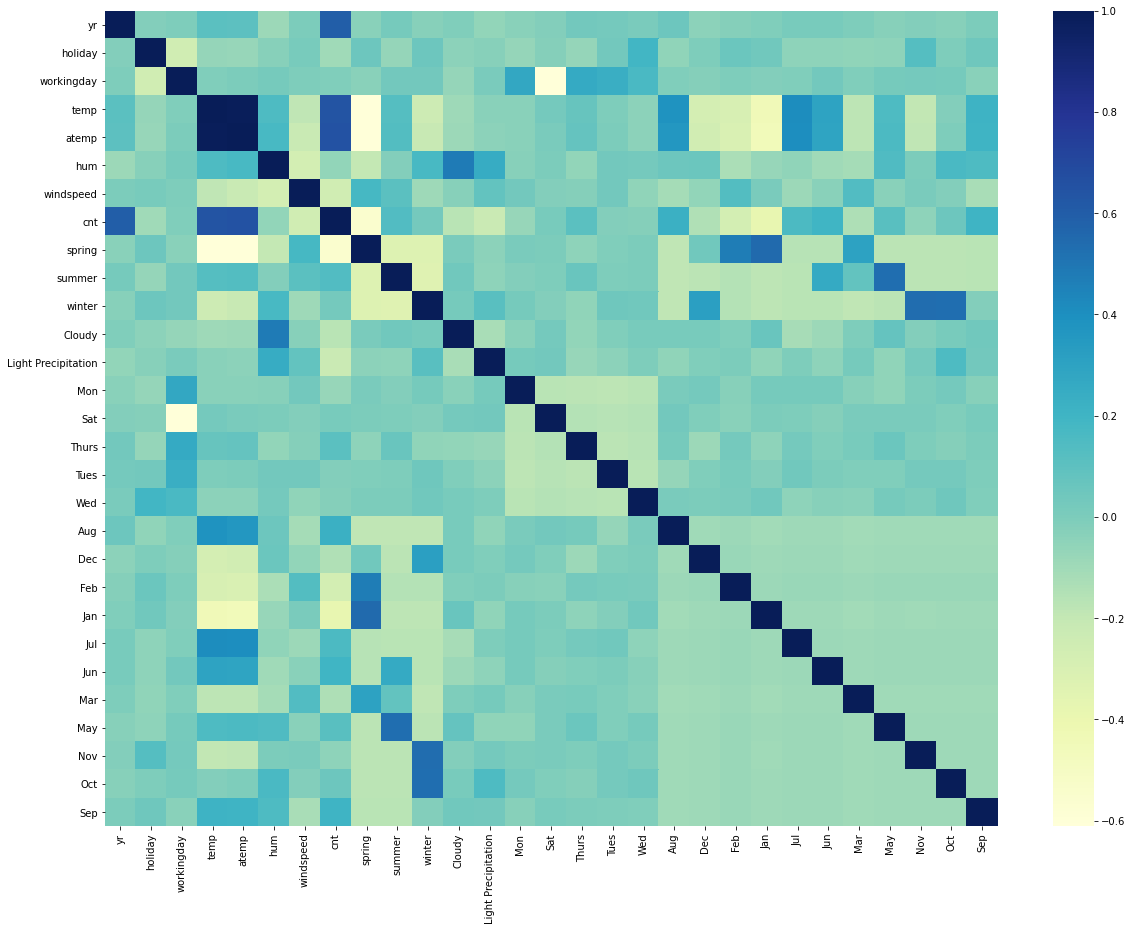

In [23]:
#check for linear relationship between variables
plt.figure(figsize=(20,15))
sns.heatmap(df_train.corr(),cmap="YlGnBu");
plt.show()

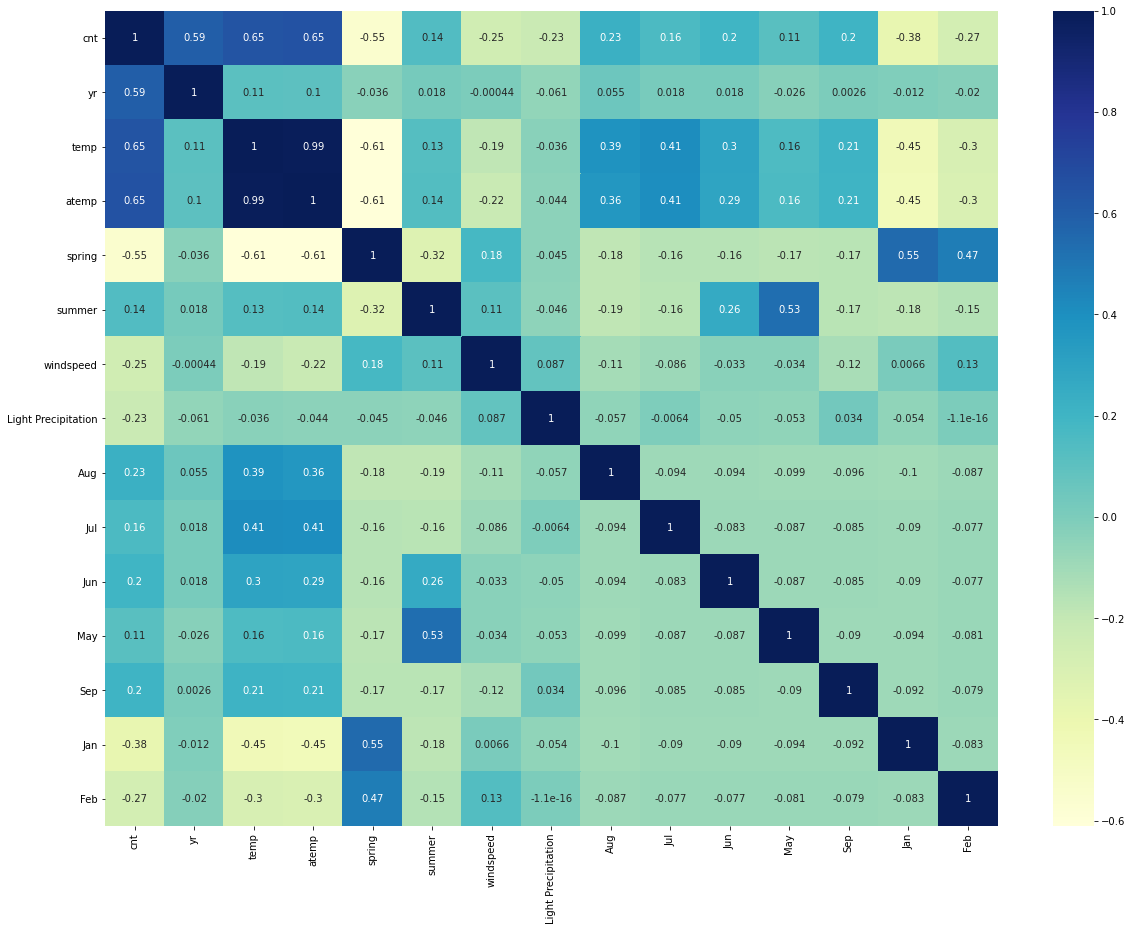

In [24]:
#We observe some variables seem to have high correlation with cnt. Plotting subset so we can get a better picture
plt.figure(figsize=(20,15))
sns.heatmap(df_train[["cnt","yr","temp","atemp","spring","summer","windspeed","Light Precipitation","Aug","Jul","Jun","May","Sep","Jan","Feb"]].corr(),annot=True,cmap="YlGnBu");
plt.show()

We see high correlation of the target variable with below variables

Positive correlation
- atemp
- temp
- yr
- Aug
- Jun

Negative correlation
- spring
- windspeed
- light precipitation
- Jan
- Feb

The correlation between the below variables is quite high and could lead to multilinearity:
- atemp and temp
- Cloudy and hum
- Winter and mnth
- working day and Sat
- May and summer
- Jan and spring

In [25]:
#extracting the y column/independent variable
y_train = df_train.pop("cnt")
X_train = df_train
y_train.head()

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [26]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,1,0.245101,0.200348,0.498067,0.663106,1,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,0


To build the model, we can take either manual or automatic approach with RFE. We will adapt a manual approach since the number of columns is not very high. We follow the below approach for the same.
- Add all variables to model.
- Based on pvalue and VIF we drop he variables one by one.
- The technique used to choose the next variable to be dropped is below:
    - High pvalue, High VIF - drop the variables
    - High-low
        - High pvalue, low VIF : remove first
        - Low pvalue, high VIF : remove these after since it could change after removing an insignificant variable
    - Low pvalue, low VIF - don't drop
    
Variables need to be dropped one by one since the significance as well as VIF could vary after dropping a variable that was causing redundancy or multicollinearity.

## Adding all variables to the model

In [27]:
#Model - 1
#add another variable
X_train_sm = sm.add_constant(X_train) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

linear_model = lr.fit()

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.41
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          1.58e-178
Time:                        16:28:16   Log-Likelihood:                 522.81
No. Observations:                 510   AIC:                            -987.6
Df Residuals:                     481   BIC:                            -864.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3409      0.045      7.638      0.000       0.253       0.429
yr                      0.2315      0.008     28.451      0.000       0.216       0.248
holiday                -0.0938      0.029     -3.197      0.001      -0.151      -0.036
workingday             -0.0120      0.015     -0.804      0.422      -0.041       0.017
temp                    0.3901      0.143      2.721      0.007       0.108       0.672
atemp                   0.0532      0.139      0.382      0.703      -0.221       0.327
hum                    -0.1569      0.039     -4.030      0.000      -0.233      -0.080
windspeed              -0.1809      0.027     -6.781      0.000      -0.233      -0.128
spring                 -0.0406      0.030     -1.341      0.181      -0.100       0.019
summer                  0.0459      0.026      1.737      0.083      -0.006       0.098
winter                  0.1115      0.028      3.950      0.000       0.056       0.167
Cloudy                 -0.0578      0.011     -5.486      0.000      -0.078      -0.037
Light Precipitation    -0.2489      0.027     -9.319      0.000      -0.301      -0.196
Mon                    -0.0236      0.015     -1.628      0.104      -0.052       0.005
Sat                    -0.0069      0.015     -0.452      0.652      -0.037       0.023
Thurs                   0.0052      0.015      0.347      0.729      -0.024       0.034
Tues                   -0.0248      0.015     -1.703      0.089      -0.054       0.004
Wed                    -0.0085      0.015     -0.566      0.572      -0.038       0.021
Aug                     0.0284      0.034      0.829      0.407      -0.039       0.096
Dec                    -0.0438      0.034     -1.293      0.197      -0.110       0.023
Feb                    -0.0369      0.033     -1.109      0.268      -0.102       0.029
Jan                    -0.0637      0.034     -1.879      0.061      -0.130       0.003
Jul                    -0.0282      0.035     -0.796      0.426      -0.098       0.041
Jun                     0.0092      0.025      0.364      0.716      -0.040       0.059
Mar                     0.0009      0.025      0.036      0.971      -0.048       0.050
May                     0.0250      0.021      1.172      0.242      -0.017       0.067
Nov                    -0.0404      0.037     -1.100      0.272      -0.112       0.032
Oct                     0.0062      0.036      0.171      0.865      -0.065       0.077
Sep                     0.0915      0.032      2.837      0.005       0.028       0.155
==============================================================================
Omnibus:                       78.632   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.958
Skew:                         

In [28]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,436.11
4,atemp,382.11
5,hum,38.21
7,spring,11.87
9,winter,11.70
2,workingday,9.91
8,summer,6.96
26,Oct,6.29
25,Nov,6.13
17,Aug,5.97


We had previously noticed in the heatmap temp and atemp had a correlation value of 0.99. This could be the reason atemp has high pvalue. Since it is more likely that the demand gets impacted by the temperature felt by the customers more than the actual temperature, we will drop the temp column and check if significance of atemp improves after model is built without the temp column. We can use R2 and adjusted R2 to check if our assumptions are correct.

In [29]:
#Model - 2
#drop temp
X = X_train.drop('temp',axis=1)

In [30]:
#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     99.42
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          5.97e-178
Time:                        16:28:16   Log-Likelihood:                 518.92
No. Observations:                 510   AIC:                            -981.8
Df Residuals:                     482   BIC:                            -863.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3587      0.044      8.071      0.000       0.271       0.446
yr                      0.2333      0.008     28.578      0.000       0.217       0.249
holiday                -0.0886      0.029     -3.006      0.003      -0.146      -0.031
workingday             -0.0121      0.015     -0.804      0.422      -0.042       0.017
atemp                   0.4116      0.046      8.993      0.000       0.322       0.502
hum                    -0.1507      0.039     -3.853      0.000      -0.228      -0.074
windspeed              -0.1654      0.026     -6.306      0.000      -0.217      -0.114
spring                 -0.0472      0.030     -1.552      0.121      -0.107       0.013
summer                  0.0382      0.026      1.444      0.149      -0.014       0.090
winter                  0.1059      0.028      3.737      0.000       0.050       0.162
Cloudy                 -0.0593      0.011     -5.607      0.000      -0.080      -0.039
Light Precipitation    -0.2474      0.027     -9.204      0.000      -0.300      -0.195
Mon                    -0.0247      0.015     -1.689      0.092      -0.053       0.004
Sat                    -0.0040      0.015     -0.261      0.794      -0.034       0.026
Thurs                   0.0052      0.015      0.349      0.727      -0.024       0.035
Tues                   -0.0254      0.015     -1.733      0.084      -0.054       0.003
Wed                    -0.0092      0.015     -0.603      0.547      -0.039       0.021
Aug                     0.0481      0.034      1.431      0.153      -0.018       0.114
Dec                    -0.0524      0.034     -1.542      0.124      -0.119       0.014
Feb                    -0.0451      0.033     -1.350      0.178      -0.111       0.021
Jan                    -0.0746      0.034     -2.200      0.028      -0.141      -0.008
Jul                    -0.0100      0.035     -0.285      0.776      -0.079       0.059
Jun                     0.0276      0.024      1.129      0.260      -0.020       0.076
Mar                    -0.0013      0.025     -0.051      0.959      -0.050       0.048
May                     0.0359      0.021      1.701      0.090      -0.006       0.077
Nov                    -0.0466      0.037     -1.264      0.207      -0.119       0.026
Oct                     0.0060      0.036      0.164      0.869      -0.066       0.078
Sep                     0.1004      0.032      3.108      0.002       0.037       0.164
==============================================================================
Omnibus:                       79.645   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.825
Skew:                          -0.754   Prob(JB):                     1.51e-49
Kurtosis:                       5.882  

In [31]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,37.71
3,atemp,32.39
6,spring,11.87
8,winter,11.68
2,workingday,9.91
7,summer,6.96
25,Oct,6.28
24,Nov,6.13
16,Aug,5.42
19,Jan,5.18


In [32]:
#Model - 3
#drop Mar - very high pvalue
X = X.drop('Mar',axis=1)

In [33]:
#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     103.5
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          5.81e-179
Time:                        16:28:16   Log-Likelihood:                 518.92
No. Observations:                 510   AIC:                            -983.8
Df Residuals:                     483   BIC:                            -869.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3579      0.041      8.640      0.000       0.277       0.439
yr                      0.2333      0.008     28.609      0.000       0.217       0.249
holiday                -0.0886      0.029     -3.008      0.003      -0.146      -0.031
workingday             -0.0121      0.015     -0.805      0.421      -0.042       0.017
atemp                   0.4120      0.045      9.137      0.000       0.323       0.501
hum                    -0.1509      0.039     -3.873      0.000      -0.227      -0.074
windspeed              -0.1654      0.026     -6.321      0.000      -0.217      -0.114
spring                 -0.0477      0.029     -1.662      0.097      -0.104       0.009
summer                  0.0384      0.026      1.481      0.139      -0.013       0.089
winter                  0.1056      0.028      3.801      0.000       0.051       0.160
Cloudy                 -0.0593      0.011     -5.613      0.000      -0.080      -0.039
Light Precipitation    -0.2474      0.027     -9.214      0.000      -0.300      -0.195
Mon                    -0.0247      0.015     -1.691      0.092      -0.053       0.004
Sat                    -0.0040      0.015     -0.260      0.795      -0.034       0.026
Thurs                   0.0052      0.015      0.349      0.727      -0.024       0.035
Tues                   -0.0254      0.015     -1.734      0.084      -0.054       0.003
Wed                    -0.0091      0.015     -0.603      0.547      -0.039       0.021
Aug                     0.0487      0.032      1.546      0.123      -0.013       0.111
Dec                    -0.0513      0.026     -1.952      0.052      -0.103       0.000
Feb                    -0.0438      0.023     -1.946      0.052      -0.088       0.000
Jan                    -0.0733      0.022     -3.260      0.001      -0.117      -0.029
Jul                    -0.0094      0.033     -0.283      0.777      -0.075       0.056
Jun                     0.0280      0.023      1.220      0.223      -0.017       0.073
May                     0.0363      0.020      1.849      0.065      -0.002       0.075
Nov                    -0.0456      0.031     -1.460      0.145      -0.107       0.016
Oct                     0.0070      0.031      0.224      0.823      -0.054       0.068
Sep                     0.1011      0.029      3.457      0.001       0.044       0.159
==============================================================================
Omnibus:                       79.675   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.687
Skew:                          -0.755   Prob(JB):                     1.62e-49
Kurtosis:                       5.880   Cond. No.                         31.2
================================================

In [34]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,35.69
3,atemp,32.39
8,winter,10.55
2,workingday,9.87
6,spring,8.26
7,summer,6.95
16,Aug,5.16
24,Oct,4.99
5,windspeed,4.92
23,Nov,4.89


In [35]:
#Model - 4
#drop Oct - very high pvalue
X = X.drop('Oct',axis=1)

In [36]:
#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     107.8
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          5.68e-180
Time:                        16:28:17   Log-Likelihood:                 518.89
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     484   BIC:                            -875.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3596      0.041      8.845      0.000       0.280       0.440
yr                      0.2332      0.008     28.655      0.000       0.217       0.249
holiday                -0.0882      0.029     -3.003      0.003      -0.146      -0.030
workingday             -0.0122      0.015     -0.809      0.419      -0.042       0.017
atemp                   0.4126      0.045      9.176      0.000       0.324       0.501
hum                    -0.1500      0.039     -3.873      0.000      -0.226      -0.074
windspeed              -0.1651      0.026     -6.323      0.000      -0.216      -0.114
spring                 -0.0490      0.028     -1.748      0.081      -0.104       0.006
summer                  0.0362      0.024      1.514      0.131      -0.011       0.083
winter                  0.1085      0.025      4.420      0.000       0.060       0.157
Cloudy                 -0.0594      0.011     -5.626      0.000      -0.080      -0.039
Light Precipitation    -0.2473      0.027     -9.220      0.000      -0.300      -0.195
Mon                    -0.0245      0.015     -1.682      0.093      -0.053       0.004
Sat                    -0.0040      0.015     -0.256      0.798      -0.034       0.026
Thurs                   0.0053      0.015      0.352      0.725      -0.024       0.035
Tues                   -0.0254      0.015     -1.735      0.083      -0.054       0.003
Wed                    -0.0091      0.015     -0.599      0.550      -0.039       0.021
Aug                     0.0459      0.029      1.587      0.113      -0.011       0.103
Dec                    -0.0555      0.019     -2.998      0.003      -0.092      -0.019
Feb                    -0.0450      0.022     -2.052      0.041      -0.088      -0.002
Jan                    -0.0744      0.022     -3.395      0.001      -0.117      -0.031
Jul                    -0.0122      0.031     -0.397      0.692      -0.073       0.048
Jun                     0.0268      0.022      1.203      0.229      -0.017       0.070
May                     0.0358      0.019      1.837      0.067      -0.002       0.074
Nov                    -0.0511      0.019     -2.657      0.008      -0.089      -0.013
Sep                     0.0977      0.025      3.921      0.000       0.049       0.147
==============================================================================
Omnibus:                       78.929   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.838
Skew:                          -0.750   Prob(JB):                     1.11e-48
Kurtosis:                       5.853   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance

In [37]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,34.37
3,atemp,31.60
2,workingday,9.87
6,spring,8.14
8,winter,7.01
7,summer,6.11
5,windspeed,4.85
16,Aug,4.51
20,Jul,4.16
24,Sep,2.80


In [38]:
#Model - 5
#drop Jun - very high pvalue
X = X.drop('Jun',axis=1)

In [39]:
#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     112.1
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          1.09e-180
Time:                        16:28:17   Log-Likelihood:                 518.13
No. Observations:                 510   AIC:                            -986.3
Df Residuals:                     485   BIC:                            -880.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3643      0.040      8.995      0.000       0.285       0.444
yr                      0.2326      0.008     28.627      0.000       0.217       0.249
holiday                -0.0897      0.029     -3.056      0.002      -0.147      -0.032
workingday             -0.0117      0.015     -0.778      0.437      -0.041       0.018
atemp                   0.4385      0.040     11.099      0.000       0.361       0.516
hum                    -0.1558      0.038     -4.050      0.000      -0.231      -0.080
windspeed              -0.1675      0.026     -6.430      0.000      -0.219      -0.116
spring                 -0.0595      0.027     -2.234      0.026      -0.112      -0.007
summer                  0.0303      0.023      1.294      0.196      -0.016       0.076
winter                  0.0974      0.023      4.281      0.000       0.053       0.142
Cloudy                 -0.0589      0.011     -5.579      0.000      -0.080      -0.038
Light Precipitation    -0.2471      0.027     -9.210      0.000      -0.300      -0.194
Mon                    -0.0241      0.015     -1.657      0.098      -0.053       0.004
Sat                    -0.0039      0.015     -0.254      0.799      -0.034       0.026
Thurs                   0.0042      0.015      0.281      0.779      -0.025       0.034
Tues                   -0.0256      0.015     -1.747      0.081      -0.054       0.003
Wed                    -0.0093      0.015     -0.614      0.539      -0.039       0.020
Aug                     0.0265      0.024      1.102      0.271      -0.021       0.074
Dec                    -0.0533      0.018     -2.892      0.004      -0.090      -0.017
Feb                    -0.0418      0.022     -1.920      0.055      -0.085       0.001
Jan                    -0.0696      0.022     -3.228      0.001      -0.112      -0.027
Jul                    -0.0335      0.025     -1.336      0.182      -0.083       0.016
May                     0.0257      0.018      1.460      0.145      -0.009       0.060
Nov                    -0.0500      0.019     -2.600      0.010      -0.088      -0.012
Sep                     0.0832      0.022      3.814      0.000       0.040       0.126
==============================================================================
Omnibus:                       77.271   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.736
Skew:                          -0.745   Prob(JB):                     2.86e-46
Kurtosis:                       5.766   Cond. No.                         26.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,34.08
3,atemp,20.81
2,workingday,9.85
6,spring,7.32
8,winter,5.98
7,summer,5.90
5,windspeed,4.84
16,Aug,3.09
20,Jul,2.77
19,Jan,2.42


In [41]:
#Model - 6
#drop Thur - high pvalue
X = X.drop('Thurs',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     117.2
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          1.03e-181
Time:                        16:28:18   Log-Likelihood:                 518.09
No. Observations:                 510   AIC:                            -988.2
Df Residuals:                     486   BIC:                            -886.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3644      0.040      9.008      0.000       0.285       0.444
yr                      0.2327      0.008     28.684      0.000       0.217       0.249
holiday                -0.0881      0.029     -3.062      0.002      -0.145      -0.032
workingday             -0.0096      0.013     -0.734      0.463      -0.035       0.016
atemp                   0.4383      0.039     11.107      0.000       0.361       0.516
hum                    -0.1560      0.038     -4.061      0.000      -0.231      -0.081
windspeed              -0.1676      0.026     -6.441      0.000      -0.219      -0.116
spring                 -0.0595      0.027     -2.236      0.026      -0.112      -0.007
summer                  0.0305      0.023      1.306      0.192      -0.015       0.076
winter                  0.0976      0.023      4.300      0.000       0.053       0.142
Cloudy                 -0.0590      0.011     -5.595      0.000      -0.080      -0.038
Light Precipitation    -0.2478      0.027     -9.284      0.000      -0.300      -0.195
Mon                    -0.0262      0.013     -2.079      0.038      -0.051      -0.001
Sat                    -0.0039      0.015     -0.256      0.798      -0.034       0.026
Tues                   -0.0277      0.013     -2.184      0.029      -0.053      -0.003
Wed                    -0.0113      0.013     -0.849      0.396      -0.038       0.015
Aug                     0.0267      0.024      1.113      0.266      -0.020       0.074
Dec                    -0.0536      0.018     -2.918      0.004      -0.090      -0.018
Feb                    -0.0416      0.022     -1.913      0.056      -0.084       0.001
Jan                    -0.0696      0.022     -3.233      0.001      -0.112      -0.027
Jul                    -0.0331      0.025     -1.321      0.187      -0.082       0.016
May                     0.0258      0.018      1.467      0.143      -0.009       0.060
Nov                    -0.0502      0.019     -2.618      0.009      -0.088      -0.013
Sep                     0.0833      0.022      3.825      0.000       0.041       0.126
==============================================================================
Omnibus:                       77.529   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.852
Skew:                          -0.747   Prob(JB):                     1.64e-46
Kurtosis:                       5.774   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:

# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,34.07
3,atemp,20.81
2,workingday,7.45
6,spring,7.32
8,winter,5.96
7,summer,5.89
5,windspeed,4.84
15,Aug,3.08
19,Jul,2.76
18,Jan,2.42


In [43]:
#Model - 7
#drop Sat - high pvalue
X = X.drop('Sat',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     122.8
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          9.49e-183
Time:                        16:28:18   Log-Likelihood:                 518.05
No. Observations:                 510   AIC:                            -990.1
Df Residuals:                     487   BIC:                            -892.7
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3625      0.040      9.119      0.000       0.284       0.441
yr                      0.2327      0.008     28.728      0.000       0.217       0.249
holiday                -0.0864      0.028     -3.085      0.002      -0.141      -0.031
workingday             -0.0077      0.011     -0.717      0.474      -0.029       0.013
atemp                   0.4383      0.039     11.118      0.000       0.361       0.516
hum                    -0.1561      0.038     -4.066      0.000      -0.231      -0.081
windspeed              -0.1674      0.026     -6.443      0.000      -0.218      -0.116
spring                 -0.0597      0.027     -2.246      0.025      -0.112      -0.007
summer                  0.0304      0.023      1.302      0.193      -0.015       0.076
winter                  0.0976      0.023      4.301      0.000       0.053       0.142
Cloudy                 -0.0589      0.011     -5.595      0.000      -0.080      -0.038
Light Precipitation    -0.2481      0.027     -9.310      0.000      -0.300      -0.196
Mon                    -0.0261      0.013     -2.080      0.038      -0.051      -0.001
Tues                   -0.0276      0.013     -2.185      0.029      -0.052      -0.003
Wed                    -0.0113      0.013     -0.847      0.398      -0.037       0.015
Aug                     0.0265      0.024      1.107      0.269      -0.021       0.074
Dec                    -0.0535      0.018     -2.916      0.004      -0.090      -0.017
Feb                    -0.0414      0.022     -1.909      0.057      -0.084       0.001
Jan                    -0.0696      0.022     -3.234      0.001      -0.112      -0.027
Jul                    -0.0331      0.025     -1.324      0.186      -0.082       0.016
May                     0.0257      0.018      1.465      0.144      -0.009       0.060
Nov                    -0.0505      0.019     -2.637      0.009      -0.088      -0.013
Sep                     0.0832      0.022      3.825      0.000       0.040       0.126
==============================================================================
Omnibus:                       76.991   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.735
Skew:                          -0.743   Prob(JB):                     4.72e-46
Kurtosis:                       5.760   Cond. No.                         26.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,33.78
3,atemp,20.49
6,spring,7.14
8,winter,5.87
7,summer,5.76
2,workingday,5.16
5,windspeed,4.83
14,Aug,3.05
18,Jul,2.75
17,Jan,2.41


In [45]:
#Model - 8
#drop working day - high pvalue, high VIF
X = X.drop('workingday',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     128.7
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          1.07e-183
Time:                        16:28:18   Log-Likelihood:                 517.78
No. Observations:                 510   AIC:                            -991.6
Df Residuals:                     488   BIC:                            -898.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3590      0.039      9.105      0.000       0.282       0.436
yr                      0.2328      0.008     28.749      0.000       0.217       0.249
holiday                -0.0793      0.026     -3.028      0.003      -0.131      -0.028
atemp                   0.4378      0.039     11.112      0.000       0.360       0.515
hum                    -0.1573      0.038     -4.106      0.000      -0.233      -0.082
windspeed              -0.1675      0.026     -6.447      0.000      -0.218      -0.116
spring                 -0.0594      0.027     -2.234      0.026      -0.112      -0.007
summer                  0.0306      0.023      1.310      0.191      -0.015       0.076
winter                  0.0980      0.023      4.322      0.000       0.053       0.143
Cloudy                 -0.0582      0.010     -5.556      0.000      -0.079      -0.038
Light Precipitation    -0.2477      0.027     -9.303      0.000      -0.300      -0.195
Mon                    -0.0298      0.011     -2.598      0.010      -0.052      -0.007
Tues                   -0.0312      0.012     -2.691      0.007      -0.054      -0.008
Wed                    -0.0149      0.012     -1.203      0.229      -0.039       0.009
Aug                     0.0271      0.024      1.130      0.259      -0.020       0.074
Dec                    -0.0533      0.018     -2.906      0.004      -0.089      -0.017
Feb                    -0.0419      0.022     -1.931      0.054      -0.085       0.001
Jan                    -0.0697      0.021     -3.241      0.001      -0.112      -0.027
Jul                    -0.0322      0.025     -1.289      0.198      -0.081       0.017
May                     0.0256      0.018      1.462      0.144      -0.009       0.060
Nov                    -0.0513      0.019     -2.686      0.007      -0.089      -0.014
Sep                     0.0836      0.022      3.844      0.000       0.041       0.126
==============================================================================
Omnibus:                       75.201   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.039
Skew:                          -0.721   Prob(JB):                     1.10e-45
Kurtosis:                       5.769   Cond. No.                         24.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,33.37
2,atemp,20.24
5,spring,7.10
7,winter,5.86
6,summer,5.72
4,windspeed,4.82
13,Aug,3.05
17,Jul,2.75
16,Jan,2.41
8,Cloudy,2.33


In [47]:
#Model - 9
#drop Aug - high pvalue, high VIF
X = X.drop('Aug',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     135.0
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          1.70e-184
Time:                        16:28:18   Log-Likelihood:                 517.12
No. Observations:                 510   AIC:                            -992.2
Df Residuals:                     489   BIC:                            -903.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3749      0.037     10.171      0.000       0.302       0.447
yr                      0.2331      0.008     28.794      0.000       0.217       0.249
holiday                -0.0801      0.026     -3.056      0.002      -0.132      -0.029
atemp                   0.4400      0.039     11.178      0.000       0.363       0.517
hum                    -0.1552      0.038     -4.054      0.000      -0.230      -0.080
windspeed              -0.1676      0.026     -6.451      0.000      -0.219      -0.117
spring                 -0.0771      0.021     -3.590      0.000      -0.119      -0.035
summer                  0.0120      0.017      0.724      0.470      -0.021       0.045
winter                  0.0816      0.017      4.676      0.000       0.047       0.116
Cloudy                 -0.0578      0.010     -5.520      0.000      -0.078      -0.037
Light Precipitation    -0.2493      0.027     -9.372      0.000      -0.302      -0.197
Mon                    -0.0294      0.011     -2.564      0.011      -0.052      -0.007
Tues                   -0.0315      0.012     -2.710      0.007      -0.054      -0.009
Wed                    -0.0146      0.012     -1.180      0.239      -0.039       0.010
Dec                    -0.0548      0.018     -2.998      0.003      -0.091      -0.019
Feb                    -0.0421      0.022     -1.938      0.053      -0.085       0.001
Jan                    -0.0699      0.021     -3.252      0.001      -0.112      -0.028
Jul                    -0.0513      0.018     -2.800      0.005      -0.087      -0.015
May                     0.0251      0.018      1.433      0.152      -0.009       0.060
Nov                    -0.0532      0.019     -2.795      0.005      -0.091      -0.016
Sep                     0.0681      0.017      4.032      0.000       0.035       0.101
==============================================================================
Omnibus:                       76.389   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.932
Skew:                          -0.729   Prob(JB):                     9.54e-47
Kurtosis:                       5.801   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,31.35
2,atemp,17.99
5,spring,5.31
4,windspeed,4.70
7,winter,3.97
6,summer,3.28
15,Jan,2.39
8,Cloudy,2.33
0,yr,2.10
14,Feb,1.92


In [49]:
#Model - 10
#drop Wed - high pvalue
X = X.drop('Wed',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          2.81e-185
Time:                        16:28:18   Log-Likelihood:                 516.39
No. Observations:                 510   AIC:                            -992.8
Df Residuals:                     490   BIC:                            -908.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3715      0.037     10.105      0.000       0.299       0.444
yr                      0.2328      0.008     28.764      0.000       0.217       0.249
holiday                -0.0861      0.026     -3.347      0.001      -0.137      -0.036
atemp                   0.4419      0.039     11.231      0.000       0.365       0.519
hum                    -0.1565      0.038     -4.087      0.000      -0.232      -0.081
windspeed              -0.1664      0.026     -6.407      0.000      -0.217      -0.115
spring                 -0.0763      0.021     -3.554      0.000      -0.118      -0.034
summer                  0.0122      0.017      0.734      0.463      -0.020       0.045
winter                  0.0810      0.017      4.640      0.000       0.047       0.115
Cloudy                 -0.0576      0.010     -5.499      0.000      -0.078      -0.037
Light Precipitation    -0.2489      0.027     -9.353      0.000      -0.301      -0.197
Mon                    -0.0267      0.011     -2.377      0.018      -0.049      -0.005
Tues                   -0.0285      0.011     -2.515      0.012      -0.051      -0.006
Dec                    -0.0541      0.018     -2.959      0.003      -0.090      -0.018
Feb                    -0.0423      0.022     -1.949      0.052      -0.085       0.000
Jan                    -0.0705      0.022     -3.276      0.001      -0.113      -0.028
Jul                    -0.0511      0.018     -2.788      0.006      -0.087      -0.015
May                     0.0247      0.018      1.409      0.159      -0.010       0.059
Nov                    -0.0518      0.019     -2.726      0.007      -0.089      -0.014
Sep                     0.0688      0.017      4.073      0.000       0.036       0.102
==============================================================================
Omnibus:                       75.000   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.238
Skew:                          -0.708   Prob(JB):                     4.96e-47
Kurtosis:                       5.834   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,31.17
2,atemp,17.98
5,spring,5.30
4,windspeed,4.70
7,winter,3.95
6,summer,3.28
14,Jan,2.38
8,Cloudy,2.33
0,yr,2.09
13,Feb,1.92


In [51]:
#Model - 11
#drop May - high pvalue
X = X.drop('May',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     149.4
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          6.07e-186
Time:                        16:28:19   Log-Likelihood:                 515.36
No. Observations:                 510   AIC:                            -992.7
Df Residuals:                     491   BIC:                            -912.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3614      0.036     10.013      0.000       0.290       0.432
yr                      0.2323      0.008     28.701      0.000       0.216       0.248
holiday                -0.0869      0.026     -3.378      0.001      -0.137      -0.036
atemp                   0.4507      0.039     11.588      0.000       0.374       0.527
hum                    -0.1494      0.038     -3.933      0.000      -0.224      -0.075
windspeed              -0.1679      0.026     -6.462      0.000      -0.219      -0.117
spring                 -0.0728      0.021     -3.412      0.001      -0.115      -0.031
summer                  0.0223      0.015      1.491      0.136      -0.007       0.052
winter                  0.0827      0.017      4.745      0.000       0.048       0.117
Cloudy                 -0.0579      0.010     -5.522      0.000      -0.078      -0.037
Light Precipitation    -0.2510      0.027     -9.436      0.000      -0.303      -0.199
Mon                    -0.0274      0.011     -2.437      0.015      -0.050      -0.005
Tues                   -0.0290      0.011     -2.552      0.011      -0.051      -0.007
Dec                    -0.0529      0.018     -2.893      0.004      -0.089      -0.017
Feb                    -0.0410      0.022     -1.888      0.060      -0.084       0.002
Jan                    -0.0689      0.021     -3.205      0.001      -0.111      -0.027
Jul                    -0.0516      0.018     -2.809      0.005      -0.088      -0.015
Nov                    -0.0502      0.019     -2.644      0.008      -0.088      -0.013
Sep                     0.0686      0.017      4.061      0.000       0.035       0.102
==============================================================================
Omnibus:                       73.509   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.117
Skew:                          -0.710   Prob(JB):                     5.78e-44
Kurtosis:                       5.712   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,31.12
2,atemp,17.95
5,spring,5.30
4,windspeed,4.62
7,winter,3.95
6,summer,2.76
14,Jan,2.38
8,Cloudy,2.33
0,yr,2.09
13,Feb,1.92


In [53]:
#Model - 12
#drop Feb - high pvalue
X = X.drop('Feb',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     157.2
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          2.78e-186
Time:                        16:28:19   Log-Likelihood:                 513.52
No. Observations:                 510   AIC:                            -991.0
Df Residuals:                     492   BIC:                            -914.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3487      0.036      9.808      0.000       0.279       0.419
yr                      0.2319      0.008     28.590      0.000       0.216       0.248
holiday                -0.0895      0.026     -3.472      0.001      -0.140      -0.039
atemp                   0.4688      0.038     12.404      0.000       0.395       0.543
hum                    -0.1516      0.038     -3.982      0.000      -0.226      -0.077
windspeed              -0.1659      0.026     -6.373      0.000      -0.217      -0.115
spring                 -0.0849      0.020     -4.160      0.000      -0.125      -0.045
summer                  0.0255      0.015      1.710      0.088      -0.004       0.055
winter                  0.0840      0.017      4.808      0.000       0.050       0.118
Cloudy                 -0.0576      0.011     -5.479      0.000      -0.078      -0.037
Light Precipitation    -0.2493      0.027     -9.354      0.000      -0.302      -0.197
Mon                    -0.0268      0.011     -2.374      0.018      -0.049      -0.005
Tues                   -0.0292      0.011     -2.566      0.011      -0.052      -0.007
Dec                    -0.0426      0.017     -2.433      0.015      -0.077      -0.008
Jan                    -0.0471      0.018     -2.591      0.010      -0.083      -0.011
Jul                    -0.0528      0.018     -2.868      0.004      -0.089      -0.017
Nov                    -0.0448      0.019     -2.382      0.018      -0.082      -0.008
Sep                     0.0702      0.017      4.148      0.000       0.037       0.103
==============================================================================
Omnibus:                       68.226   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.657
Skew:                          -0.658   Prob(JB):                     4.84e-41
Kurtosis:                       5.647   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,30.51
2,atemp,17.43
4,windspeed,4.61
5,spring,4.19
7,winter,3.95
6,summer,2.76
8,Cloudy,2.32
0,yr,2.08
15,Nov,1.84
13,Jan,1.75


In [55]:
#Model - 13
#drop summer - high pvalue
X = X.drop('summer',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     166.2
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          9.05e-187
Time:                        16:28:19   Log-Likelihood:                 512.01
No. Observations:                 510   AIC:                            -990.0
Df Residuals:                     493   BIC:                            -918.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3760      0.032     11.806      0.000       0.313       0.439
yr                      0.2323      0.008     28.598      0.000       0.216       0.248
holiday                -0.0893      0.026     -3.461      0.001      -0.140      -0.039
atemp                   0.4429      0.035     12.764      0.000       0.375       0.511
hum                    -0.1455      0.038     -3.830      0.000      -0.220      -0.071
windspeed              -0.1617      0.026     -6.228      0.000      -0.213      -0.111
spring                 -0.1082      0.015     -7.091      0.000      -0.138      -0.078
winter                  0.0663      0.014      4.702      0.000       0.039       0.094
Cloudy                 -0.0582      0.011     -5.534      0.000      -0.079      -0.038
Light Precipitation    -0.2525      0.027     -9.483      0.000      -0.305      -0.200
Mon                    -0.0270      0.011     -2.391      0.017      -0.049      -0.005
Tues                   -0.0286      0.011     -2.509      0.012      -0.051      -0.006
Dec                    -0.0472      0.017     -2.725      0.007      -0.081      -0.013
Jan                    -0.0509      0.018     -2.815      0.005      -0.086      -0.015
Jul                    -0.0641      0.017     -3.724      0.000      -0.098      -0.030
Nov                    -0.0497      0.019     -2.669      0.008      -0.086      -0.013
Sep                     0.0586      0.016      3.772      0.000       0.028       0.089
==============================================================================
Omnibus:                       68.673   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.660
Skew:                          -0.661   Prob(JB):                     1.78e-41
Kurtosis:                       5.662   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,25.39
2,atemp,16.87
4,windspeed,4.05
6,winter,2.95
5,spring,2.89
7,Cloudy,2.28
0,yr,2.07
14,Nov,1.83
12,Jan,1.75
11,Dec,1.55


In [57]:
#now all variables have pvalue less tha 0.05. We look at variables that still have VIF above 5.

#Model - 14
#drop hum - highest VIF
X = X.drop('hum',axis=1)

#create a model without the dropped variable

#add another variable
X_train_sm = sm.add_constant(X) #since we want all columns

#create next model
lr = sm.OLS(y_train,X_train_sm)

lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     171.5
Date:                Sun, 07 Mar 2021   Prob (F-statistic):          8.99e-185
Time:                        16:28:19   Log-Likelihood:                 504.53
No. Observations:                 510   AIC:                            -977.1
Df Residuals:                     494   BIC:                            -909.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3020      0.026     11.767      0.000       0.252       0.352
yr                      0.2359      0.008     28.831      0.000       0.220       0.252
holiday                -0.0901      0.026     -3.443      0.001      -0.142      -0.039
atemp                   0.4088      0.034     12.024      0.000       0.342       0.476
windspeed              -0.1363      0.025     -5.358      0.000      -0.186      -0.086
spring                 -0.1108      0.015     -7.169      0.000      -0.141      -0.080
winter                  0.0581      0.014      4.115      0.000       0.030       0.086
Cloudy                 -0.0814      0.009     -9.335      0.000      -0.099      -0.064
Light Precipitation    -0.2935      0.025    -11.874      0.000      -0.342      -0.245
Mon                    -0.0274      0.011     -2.389      0.017      -0.050      -0.005
Tues                   -0.0322      0.012     -2.795      0.005      -0.055      -0.010
Dec                    -0.0528      0.017     -3.015      0.003      -0.087      -0.018
Jan                    -0.0561      0.018     -3.068      0.002      -0.092      -0.020
Jul                    -0.0563      0.017     -3.249      0.001      -0.090      -0.022
Nov                    -0.0493      0.019     -2.610      0.009      -0.086      -0.012
Sep                     0.0554      0.016      3.526      0.000       0.025       0.086
==============================================================================
Omnibus:                       70.963   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.192
Skew:                          -0.691   Prob(JB):                     8.27e-42
Kurtosis:                       5.645   Cond. No.                         15.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# Create a dataframe that will contain the names of the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,4.67
3,windspeed,4.01
5,winter,2.59
4,spring,2.36
0,yr,2.06
13,Nov,1.81
11,Jan,1.65
6,Cloudy,1.54
10,Dec,1.47
12,Jul,1.35


We see the VIF for temp has dropped significantly now. All the VIF values are below 5 and pvalues below 0.05.

## Residual analysis

In [59]:
#computing the predicted values
y_train_pred = lr_model.predict(X_train_sm)

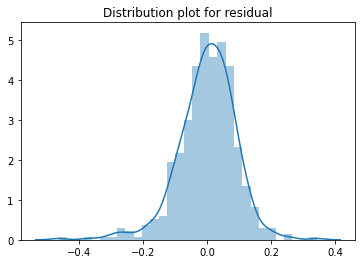

In [60]:
res = y_train - y_train_pred
sns.distplot(res);
plt.title("Distribution plot for residual");

Residual plot is normally distributed with mean at 0. In case it wasn't, it would mean the model failed to capture a pattern in the data. 

<b> Validating Homoscedasticity </b>

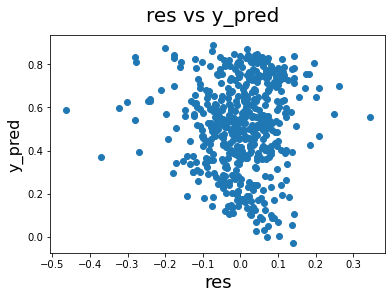

In [61]:
 #A scatterplot of residuals versus predicted values is good way to check for homoscedasticity
fig = plt.figure()
plt.scatter(res, y_train_pred)

fig.suptitle('res vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('res', fontsize = 18)  ;                        # X-label
plt.ylabel('y_pred', fontsize = 16) ;

We see there is no clear pattern. It means the data is homoscedastic, which is one of the assumptions of linear regression.

### Preparation, prediction and evaluation on the test set

Applying the scaling on test dataset

In [62]:
numvars = ['temp','atemp','hum','windspeed','cnt']

#The scaler is already fit on the training data. We only perform transform on test set
df_test[numvars] = scaler.transform(df_test[numvars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,1,0,0,0,0,0
299,0,0,0,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,0,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,0,1,0,0,0,0,0


In [63]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.100000,0.077273,0.104545,0.095455,0.054545,0.086364,0.072727,0.086364,0.086364
std,0.500809,0.187620,0.480828,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.300684,0.267633,0.306665,0.294512,0.227609,0.281541,0.260281,0.281541,0.281541
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We don't see exact 1 and 0 is the min and max since the scaler was fit to the training set. However, we have successfully rescaled the feature to the same scale as the model now.

In [64]:
#extract the y from test set
y_test = df_test.pop('cnt')
X_test = df_test

In [65]:
#add a constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,0,0,0,1,0,0,0,0,0,0
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,...,0,0,0,0,1,0,0,0,0,0
299,1.0,0,0,0,0.511964,0.496145,0.837699,0.334206,0,0,...,0,0,0,0,0,0,0,0,1,0
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,0,0,0,0.817246,0.741471,0.314298,0.537414,0,1,...,0,0,0,0,1,0,0,0,0,0


In [66]:
#predict
y_test_pred = linear_model.predict(X_test_sm)

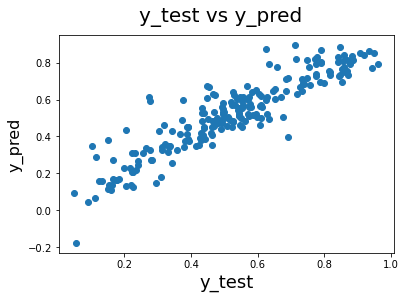

In [67]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)  ;                        # X-label
plt.ylabel('y_pred', fontsize = 16) ;


### R2 Score on test set

In [68]:
#evaluate
r2_score(y_true = y_test, y_pred = y_test_pred)

0.8295925360626363

Multi linear regression on the model was done with a backward approach where the model started with all the variables. Based on the business understanding, the thresholds set for pvalue and VIFs, feature selection was done. The final model has an r2 of 0.839 and adjusted r2 of 0.834 on the training dataset. The test dataset has an r2 score of 0.829. This means the model has generalized well and is able to perform well on new set of data points. 

Summary of the final model

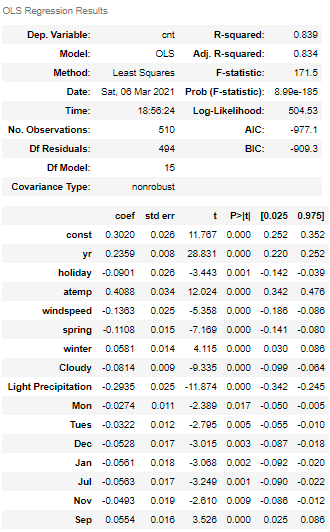




Best fitted line can be represented with the below equation -

#### <i> y = 0.3020 + 0.2359 x yr -0.0901 x holiday + 0.4088 x atemp - 0.1363 x windspeed - 0.1108 x spring + 0.0581 x winter - 0.0814 -0.2935 x Light Precipitation =0.0274 x Mon - 0.0322 x Tues - 0.0528 x Dec - 0.0561 x Jan - 0.0561 x Jul - 0.0493 x Nov + 0.0554 x Sep </i> 

We see the below variables are the 3 most significant variables in the model.

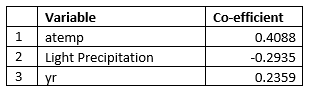

We can infer that weather conditions(what temperature it feels like, rain) and year are amongst most important factors. the company needs to be prepared for a slight rise in demand with rise in temperature and a dip in demand on days when light precipitation is expected. 

The fact that year is positively correlated could be due to its growing popularity. 